This notebook is a continuation of `09_classifier.ipynb`. We built some basic classification models using tree-based classifiers in that notebook. In this notebook, we will optimize the hyper-parameters of those models to try to improve their performance. The full version of this notebook is available in `11_classifier_fine_tuning.ipynb`. The dataset used for this exercise is borrowed from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients).

### Import packages

In [1]:
# data processing
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# grid search
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Set-up

In [2]:
# input file location and name
infile = 'https://raw.githubusercontent.com/vishal-git/dapt-631/main/data/credit_default_model_data.csv'

# target variable (column name)
target = 'default payment next month'

sns.set(style='darkgrid')

### Read data

In [3]:
df = pd.read_csv(infile)

df.shape

(30000, 57)

In [4]:
df.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,pay_bucket_-2_flag,pay_bucket_-1_flag,pay_amt_total,bill_amt_total,pay_to_billed_ratio,zero_bill_amount,utilization_avg,utilization_max,group,default payment next month
0,40000,28,10371,11895,11228,2475,5341,6255,2567,0,...,0,1,11883,47565,0.249827,0,0.198187,0.297375,M,1
1,320000,35,12233,16490,20011,17918,18627,19167,7000,4100,...,0,0,15100,104446,0.144572,0,0.054399,0.062534,M,0
2,260000,35,188,188,188,188,194,188,188,188,...,0,1,1167,1134,1.029101,0,0.000727,0.000746,M,0
3,360000,36,308711,305594,306176,304645,315118,315782,11000,13000,...,0,0,71322,1856026,0.038427,0,0.859271,0.877172,M,0
4,500000,25,-46,9412,1260,0,1121,6566,9458,1260,...,0,1,20839,18313,1.137935,0,0.006104,0.018824,M,0


### Set-up X and y

In [5]:
y = df[target]
X = df.drop(target, axis=1)

X_train = X[X['group'] == 'M'].drop('group', axis=1)
X_test = X[X['group'] == 'T'].drop('group', axis=1)
X_valid = X[X['group'] == 'V'].drop('group', axis=1)

y_train = y[X['group'] == 'M']
y_test = y[X['group'] == 'T']
y_valid = y[X['group'] == 'V']

print(len(X_train), len(X_test), len(X_valid))

del df

15000 7500 7500


### Decision Tree

We will fine-tune hyper-parameters for decision (classification) tree now.

#### Max Depth

In [8]:
# create a list of all values we would like to test
max_depths = [x + 1 for x in list(range(20))]
max_depths

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

We will build a decision tree model using each value of `max_depth`. Once all models are built, we will pick the best value for `max_depth` based on the model performance on the test set.

In [13]:
# create empty arrays -- we will use these to store model performance values
auc_train, auc_test = [], []

for d in max_depths:
    tree = DecisionTreeClassifier(max_depth=d, random_state=314)
    tree.fit(X_train, y_train)

    scores_train = tree.predict_proba(X_train)[:, 1]
    scores_test = tree.predict_proba(X_test)[:, 1]

    _auc_train = roc_auc_score(y_train, scores_train)
    _auc_test = roc_auc_score(y_test, scores_test)

    auc_train.append(_auc_train)
    auc_test.append(_auc_test)


Let's plot the model performances.

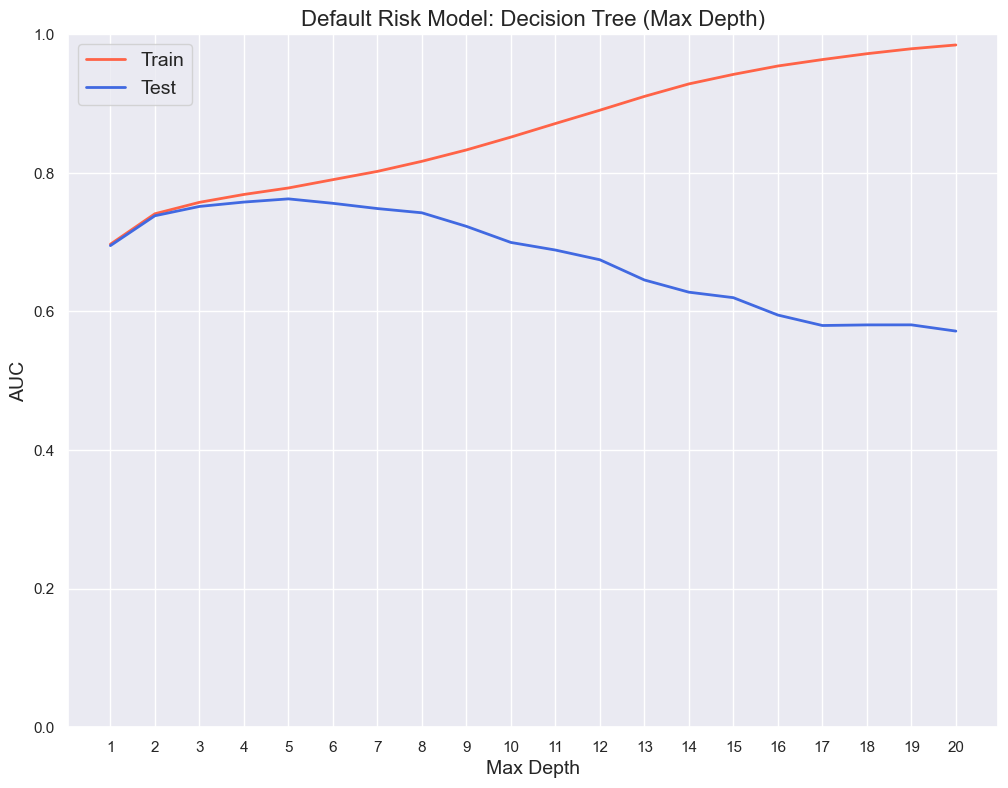

In [35]:
plt.figure(figsize=(12, 9))

plt.plot(max_depths, auc_train, color='tomato', lw=2, label='Train')
plt.plot(max_depths, auc_test, color='royalblue', lw=2, label='Test')

plt.xticks(max_depths)
plt.ylim([0.0, 1.0])

plt.xlabel('Max Depth', fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.title('Default Risk Model: Decision Tree (Max Depth)', fontsize=16)
plt.legend(loc='best', fontsize=14);

Find out where AUC on the test set maximizes.

In [24]:
auc_test

[0.6949693034451732,
 0.7380894350159106,
 0.7515132256258353,
 0.7578341790826665,
 0.7624471286940131,
 0.756037457760424,
 0.7484754858577468,
 0.7423484383261142,
 0.7228086834552219,
 0.6995709132286634,
 0.6886262347584504,
 0.6745849109890218,
 0.645418360628282,
 0.6278074540331612,
 0.6198743978089605,
 0.594809222020078,
 0.5797201699927426,
 0.5805923105089109,
 0.5806586048871476,
 0.5716505740313222]

In [29]:
max_val = max(auc_test)
best_loc = [i for i, auc_test_val in enumerate(auc_test)
            if auc_test_val == max_val]
best_loc

[4]

In [26]:
best_auc = max(auc_test)
best_auc

0.7624471286940131

In [31]:
best_max_depth = best_loc
best_max_depth

[4]

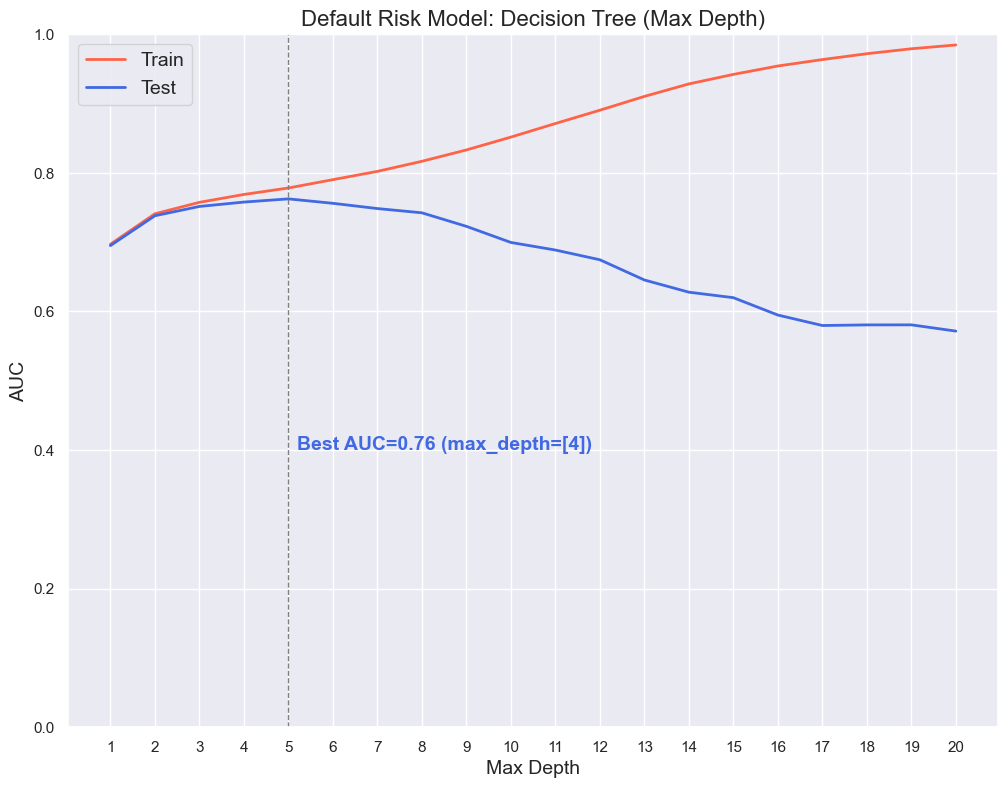

In [34]:
plt.figure(figsize=(12, 9))

plt.plot(max_depths, auc_train, color='tomato', lw=2, label='Train')
plt.plot(max_depths, auc_test, color='royalblue', lw=2, label='Test')

plt.plot([5, 5], [0, 1], color='gray', linewidth=1, linestyle='--')
plt.text(5+.2, 0.4, f'Best AUC={best_auc:.2f} (max_depth={best_max_depth})', fontsize=14,
         color='royalblue', weight='semibold')

plt.xticks(max_depths)
plt.ylim([0.0, 1.0])

plt.xlabel('Max Depth', fontsize = 14)
plt.ylabel('AUC', fontsize = 14)
plt.title('Default Risk Model: Decision Tree (Max Depth)', fontsize = 16)
plt.legend(loc='best', fontsize = 14);

#### Minimum Samples in the leaf nodes

In [36]:
# create a list of all values we would like to test
min_smpl_leaf = [0.4, 0.3, 0.2, 0.1, 0.05, 0.02, 0.01, 0.001]

# create empty arrays -- we will use these to store model performance values
auc_train, auc_test = [], []

for msl in min_smpl_leaf:
    
    #--

SyntaxError: incomplete input (2911449230.py, line 9)

In [37]:
# identify the best value for min_samples_leaf
best_loc = [i for i, auc_test_value in enumerate(auc_test) if auc_test_value == max(auc_test)][0]
best_auc = auc_test[best_loc]
best_msl = min_smpl_leaf[best_loc]

NameError: name 'min_smpl_leaf' is not defined

In [33]:
# plot the model performances
plt.figure(figsize=(12, 9))

plt.plot(min_smpl_leaf, auc_train, color='tomato', lw=2, label='Train')

plt.plot(min_smpl_leaf, auc_test, color='royalblue', lw=2, label='Test')

plt.plot([best_msl, best_msl], [0, 1], color='gray', linewidth=1, linestyle='--')
plt.text(0.2, 0.7, f'Best AUC={best_auc:.2f} (min_smpl_leaf={best_msl})', fontsize=14,
         color='royalblue', weight='semibold')

plt.xticks(min_smpl_leaf)
plt.xlim([max(min_smpl_leaf), min(min_smpl_leaf)])
plt.xscale('log')
plt.ylim([0.5, 1.0])

plt.xlabel('Min Samples Leaf', fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.title('Default Risk Model: Decision Tree (Min Samples Leaf)', fontsize=16)
plt.legend(loc='best', fontsize=14);

NameError: name 'min_smpl_leaf' is not defined

<Figure size 1200x900 with 0 Axes>

#### Grid-search

Instead of testing (fine-tuning) one hyper-parameter at a time, we can use grid search to assess combination of hyper-parameters.

In [39]:
tree = DecisionTreeClassifier(random_state=314)

# create a list of all parameters we want to test
param_grid = {'max_depth': [4,5], 'min_samples_leaf': [.02, .05]}

# define the gridsearch object
tree_gs = GridSearchCV(tree, param_grid, cv=3, verbose=2, n_jobs=-1)

# fit the model
tree_gs.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=314),
             n_jobs=-1,
             param_grid={'max_depth': [4, 5], 'min_samples_leaf': [0.02, 0.05]},
             verbose=2)

Find the best set of hyper-parameters.

In [40]:
tree_gs.best_params_

{'max_depth': 4, 'min_samples_leaf': 0.02}

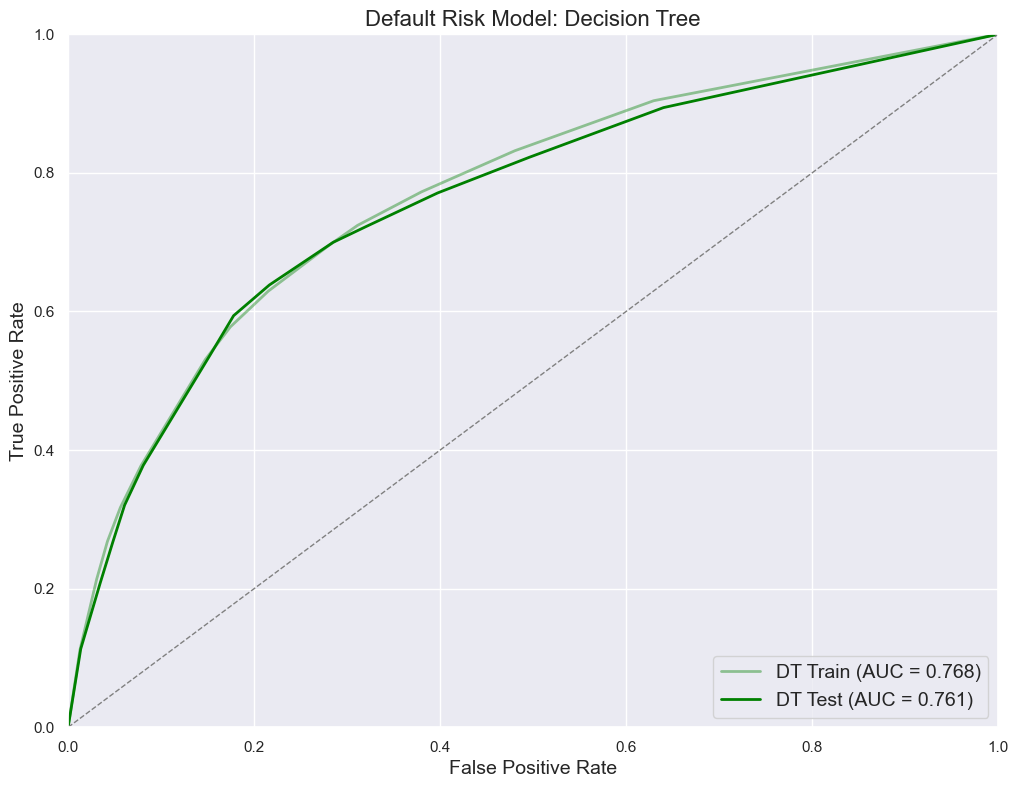

In [41]:
tree_scores_train = tree_gs.predict_proba(X_train)[:, 1]
tree_scores_test = tree_gs.predict_proba(X_test)[:, 1]

tree_fpr_train, tree_tpr_train, _ = roc_curve(y_train, tree_scores_train)
tree_fpr_test, tree_tpr_test, _ = roc_curve(y_test, tree_scores_test)

plt.figure(figsize=(12, 9))

plt.plot(tree_fpr_train, tree_tpr_train, color='green', lw=2, alpha = 0.4, linestyle = '-',
         label=f'DT Train (AUC = {roc_auc_score(y_train, tree_scores_train):0.3f})')

plt.plot(tree_fpr_test, tree_tpr_test, color='green', lw=2, linestyle = '-',
         label=f'DT Test (AUC = {roc_auc_score(y_test, tree_scores_test):0.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Default Risk Model: Decision Tree', fontsize = 16)
plt.legend(loc='lower right', fontsize = 14);

### Random Forest

Insted of testing every combination of hyper-parameters, we can perform a random test which picks random combinations from the given set.

We will perform a random-search to optimize the following hyperparameters for a Random Forest model.

Number of trees in random forest: `n_estimators = [200, 300]`

Maximum number of levels in tree: `max_depth = [3, 6]`

Minimum percentage of samples required in the leaf nodes: `min_samples_leaf = [0.02, 0.05]`

Whether to select sub-samples for training each tree: `bootstrap = [True, False]`

In [44]:
forest = RandomForestClassifier(random_state=314)

param_grid = {'n_estimators': [200, 300],
              'max_depth': [3,6],
              'min_samples_leaf': [0.02, 0.05],
              'bootstrap': [True, False]}

forest_gs = RandomizedSearchCV(forest, param_grid, cv=3, verbose=2, n_iter=10, n_jobs=-1, random_state=314)

forest_gs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=314),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 6],
                                        'min_samples_leaf': [0.02, 0.05],
                                        'n_estimators': [200, 300]},
                   random_state=314, verbose=2)

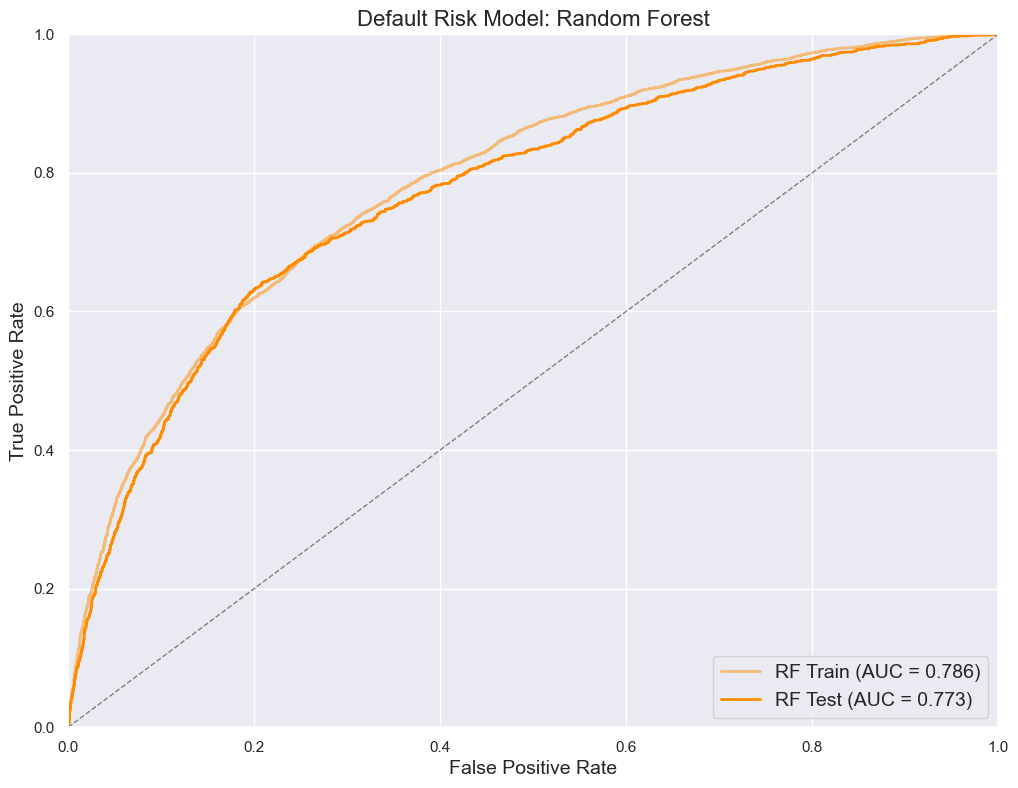

In [45]:
forest_scores_train = forest_gs.predict_proba(X_train)[:, 1]
forest_scores_test = forest_gs.predict_proba(X_test)[:, 1]

forest_fpr_train, forest_tpr_train, _ = roc_curve(y_train, forest_scores_train)
forest_fpr_test, forest_tpr_test, _ = roc_curve(y_test, forest_scores_test)

plt.figure(figsize=(12, 9))

plt.plot(forest_fpr_train, forest_tpr_train, color='darkorange', lw=2, alpha = 0.5, linestyle = '-',
         label=f'RF Train (AUC = {roc_auc_score(y_train, forest_scores_train):0.3f})')

plt.plot(forest_fpr_test, forest_tpr_test, color='darkorange', lw=2, linestyle = '-',
         label=f'RF Test (AUC = {roc_auc_score(y_test, forest_scores_test):0.3f})')


plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Default Risk Model: Random Forest', fontsize = 16)
plt.legend(loc='lower right', fontsize = 14);

Note: Once you find the best set of hyper-parameters, you can further refine them by performing another random search using a new set of hyper-parameters -- the new values (to be tested) can be chosen based on the results from the first random search.

Next, we will perform a random-search to optimize the following hyperparameters for a *Gradient Boosting* model.

Number of trees: `n_estimators = [100, 300, 500]`

Learning rate: `learning_rate = [0.05, 0.1]`

Maximum number of levels in tree: `max_depth = [3, 6]`

Minimum percentage of samples required in the leaf nodes: `min_samples_leaf = [0.01, 0.02, 0.05]`


In [ ]:
# initialize a model
gbm = 

# create a list of all parameters we want to test
param_grid = 

# define the gridsearch object
gbm_rs = 

# fit the model
gbm_rs.fit(X_train, y_train)

print ('Best GBM Parameters:', gbm_rs.best_params_)

In [ ]:
# model scores
gbm_scores_train = 
gbm_scores_test = 

# ROC curve data
gbm_fpr_train, gbm_tpr_train, _ = 
gbm_fpr_test, gbm_tpr_test, _ = 

In [ ]:
# ROC Curve
plt.figure(figsize=(12, 9))

plt.plot(gbm_fpr_train, gbm_tpr_train, color='purple', lw=2, alpha = 0.2, linestyle = '-',
         label=f'GBM Train (AUC = {roc_auc_score(y_train, gbm_scores_train):0.3f})')

plt.plot(gbm_fpr_test, gbm_tpr_test, color='purple', lw=2, linestyle = '-',
         label=f'GBM Test (AUC = {roc_auc_score(y_test, gbm_scores_test):0.3f})')

;